In [1]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import pandas as pd
import numpy as np
import csv
import MeCab
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import re
import neologdn
import demoji
import emoji
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set()
import japanize_matplotlib

model_dir = '/Users/iomacbookair2/Documents/lab/DEIM2023/entity_vector/entity_vector.model.bin'
# model_dir = '/Users/labimac/Documents/lab/DEIM2023/entity_vector/entity_vector.model.bin'
model_word2vec = KeyedVectors.load_word2vec_format(model_dir, binary=True)
mecab = MeCab.Tagger(
    '-d /opt/homebrew/lib/mecab/dic/mecab-ipadic-neologd')


In [2]:
path = "/Users/iomacbookair2/Documents/lab/DEIM2023/tweet_csv/ann/230121_ann.csv"
# path = "/Users/labimac/Documents/lab/DEIM2023/tweet_csv/221214_ann_wed.csv"

df = pd.read_csv((path))
df.sort_values(by = 'created_at', ascending = True, inplace = True)
df = df.reset_index(drop=True)
df['created_at'] = pd.to_datetime(df['created_at'])
df = df.drop("author_id", axis=1)
df = df.drop("username", axis=1)
df = df.drop("tweet_id", axis=1)
df = df.drop("like_count", axis=1)
df = df.drop("retweet_count", axis=1)
df

,created_at,text
0,2023-01-22 01:00:00,#annkw
1,2023-01-22 01:00:00,#annkw
2,2023-01-22 01:00:00,#annkw
3,2023-01-22 01:00:00,#annkw
4,2023-01-22 01:00:00,#annkw
...,...,...
10283,2023-01-22 03:03:59,モアイやん #annkw https://t.co/c25izyu5AY
10284,2023-01-22 03:04:24,春日のほのぼの家庭話(説明長い)、車の購入を検討する春日、DayDayもう1人のMC、山ちゃ...
10285,2023-01-22 03:04:29,久々にハチャメチャな若林さん聴けて嬉しかった。月曜日からどんより続いていたけど少し元気出た。...
10286,2023-01-22 03:04:40,OneTalkはランダムな人と通話ができます!! 一期一会の会話ができます!! 嫌な人は簡単...


In [3]:
def preprocess(text):
    text = emoji.replace_emoji(text, replace=' ')
    text = re.sub(r'#\S+', '', text) # ハッシュタグを消す
    text = re.sub(r'＃\S+', '', text) # ハッシュタグを消す
    text = re.sub(r'@\S+', '', text) # @を消す
    text = re.sub(r'http?://[\w/:%#\$&\?\(\)~\.=\+\-]+', '', text) # URLをスペースに置き換え
    text = re.sub(r'https?://\S+', ' ', text) # URLをスペースに置き換え
    text = re.sub(r'!-/:-@[-`{-~]', r'', text) # 記号を消す
    text = re.sub(r'”', '', text)  # "を消す
    text = re.sub(r'"', '', text)  # "を消す
    text = re.sub(r"'", "", text) # 'を消す
    text = re.sub(r'[(-`)]', '', text)
    text = re.sub(
        "[\uFF01-\uFF0F\uFF1A-\uFF20\uFF3B-\uFF40\uFF5B-\uFF65\u3000-\u303F]", '', text)  # 記号を消す
    text = re.sub(
        u'[■-♯【】「」『』;・ㅂﾟˊᗜ┏━┓┗┛ヾθ、│!-/`:-@-`{-~。|∀!〇╰`′‵ˋω.*…╭∇^_￣´｀•˘д↑艸╯→°д̀ᴗ˃˂⁽⁾φ└＼※彡𖥦←ꂹ]', '', text)  # 記号を消す
    text = re.sub(r'(\d)([,.])(\d+)', r'\1\3', text) # 小数点とカンマを消す
    text = re.sub(r'\d+', '0', text) # 数字を0に置き換え
    text = text.lower() # 英字を小文字に
    text = re.sub(r"[\u3000\t\r\n]", " ", text) # 空白文字をスペースに置き換え
    text = neologdn.normalize(text)
    return text


df['text'] = df['text'].apply(preprocess)
df


,created_at,text
0,2023-01-22 01:00:00,
1,2023-01-22 01:00:00,
2,2023-01-22 01:00:00,
3,2023-01-22 01:00:00,
4,2023-01-22 01:00:00,
...,...,...
10283,2023-01-22 03:03:59,モアイやん
10284,2023-01-22 03:04:24,春日のほのぼの家庭話説明長い車の購入を検討する春日ayayもう人の山ちゃんの恨み年向井のピア...
10285,2023-01-22 03:04:29,久にハチャメチャな若林さん聴けて嬉しかった月曜日からどんより続いていたけど少し元気出た楽しか...
10286,2023-01-22 03:04:40,nealkはランダムな人と通話ができます一期一会の会話ができます嫌な人は簡単にブロック


In [4]:
# df.to_csv('preprocessed.csv', index=False)

In [5]:
import requests

url = "http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt"
r = requests.get(url)
tmp = r.text.split('\r\n')
stopwords = []
for i in range(len(tmp)):
    if len(tmp[i]) < 1:
        continue
    stopwords.append(tmp[i])

# stopwords += ["w", "ww", "www", "wwww", "wwwww", "笑",
#               "の", "し", "さ", "て", "れ", "ない", "てる",]

In [6]:
def words_list(sentence, model, mecab):
    if not sentence:
      pass
    else:
        pre_sentence = sentence.split(" ")
        sentence_words = []
        for s in pre_sentence:
            tokens = mecab.parse(s).split("\n")[:-2]
            for token in tokens:
                parts = token.split("\t")
                # features = parts[1].split(",")
                if parts[1].startswith("名詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("動詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("形容詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("副詞"):
                    sentence_words.append(parts[0])
    #     filtered_words = [
    #         word for word in sentence_words if word not in stopwords]
    # return filtered_words
    return sentence_words


df["words"] = df["text"].apply(
    lambda x: 0 if len(x) <= 1 else words_list(x, model_word2vec, mecab))
df


,created_at,text,words
0,2023-01-22 01:00:00,,0
1,2023-01-22 01:00:00,,0
2,2023-01-22 01:00:00,,0
3,2023-01-22 01:00:00,,0
4,2023-01-22 01:00:00,,0
...,...,...,...
10283,2023-01-22 03:03:59,モアイやん,[モアイ]
10284,2023-01-22 03:04:24,春日のほのぼの家庭話説明長い車の購入を検討する春日ayayもう人の山ちゃんの恨み年向井のピア...,"[春日, ほのぼの, 家庭, 話, 説明, 長い, 車, 購入, 検討, する, 春日, a..."
10285,2023-01-22 03:04:29,久にハチャメチャな若林さん聴けて嬉しかった月曜日からどんより続いていたけど少し元気出た楽しか...,"[久, ハチャメチャ, 若林, さん, 聴け, 嬉しかっ, 月曜日, どんより, 続い, い..."
10286,2023-01-22 03:04:40,nealkはランダムな人と通話ができます一期一会の会話ができます嫌な人は簡単にブロック,"[nealk, ランダム, 人, 通話, でき, 一期一会, 会話, でき, 嫌, 人, 簡..."


In [7]:
groups = df.groupby(pd.Grouper(key='created_at', freq='min'))
df_words = pd.DataFrame({
    "words": groups.apply(lambda x: [word for sublist in x["words"] if type(sublist) == list for word in sublist])
})
df_words = df_words.reset_index()
df_words


,created_at,words
0,2023-01-22 01:00:00,"[ひとつ, よしなに, ニチレイプレゼンツ, 始まり, 回, ひとつ, よしなに, オードリ..."
1,2023-01-22 01:01:00,"[春日, 離婚, 離婚, し, そう, ww, 寝, 落ちる, 離婚, し, そう, ん, ..."
2,2023-01-22 01:02:00,"[マジで, そう, w, 番, 絶対無理, w, 別件, 枕, こと, ネットニュース, な..."
3,2023-01-22 01:03:00,"[ひとつ, よしなに, オードリーのオールナイトニッポン, 聞い, い, 離婚, し, そう..."
4,2023-01-22 01:04:00,"[寝耳, 春日, 相変わらず, ピンク, 財布, wwwww, 黄色, 財布, ブリンブリン..."
...,...,...
120,2023-01-22 03:00:00,"[ミッフィー, ちゃん, アディオス, ミッフィー, ちゃん, アディオス, 現在, トレン..."
121,2023-01-22 03:01:00,"[骨壺, ない, 墓, 金庫, めちゃくちゃ, 面白かっ, 絶対, 録音, し, 何回, 聴..."
122,2023-01-22 03:02:00,"[聴き, どころ, なかっ, w, 眠く, 寝, 今週, 最高, nealk, ランダム, ..."
123,2023-01-22 03:03:00,"[ここ, 週, カスミン, 株, だいぶ, 落ち, てる, の, 面白い, 今日, 特に, ..."


In [8]:
df_words.to_csv('words.csv', index=False)

In [9]:
def save_wordclowd(words, index):
    if len(words) == 0:
        plt.axis("off")
    else:
        wordcloud = WordCloud(background_color="white", width=600, height=400, min_font_size=15,
                              font_path='/Users/iomacbookair2/Library/Fonts/IBMPlexSansJP-Regular.otf').generate(' '.join(words))
        plt.axis("off")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.savefig(f"{index}.png")
    plt.clf()


df_words.apply(lambda x: save_wordclowd(x["words"], x.name), axis=1)


0      None
1      None
2      None
3      None
4      None
       ... 
120    None
121    None
122    None
123    None
124    None
Length: 125, dtype: object

<Figure size 640x480 with 0 Axes>

In [10]:
def word_to_vec(sentence, model, mecab):
    if not sentence:
        sentence_embedding = np.zeros(200, dtype=np.float32)
    else:
        pre_sentence = sentence.split(" ")
        sentence_words = []
        for s in pre_sentence:
            tokens = mecab.parse(s).split("\n")[:-2]
            for token in tokens:
                parts = token.split("\t")
                # features = parts[1].split(",")
                if parts[1].startswith("名詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("動詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("形容詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("副詞"):
                    sentence_words.append(parts[0])
                # if parts[1].startswith("名詞"):
                #     sentence_words.append(features[6])
                # elif parts[1].startswith("動詞"):
                #     sentence_words.append(features[6])
                # elif parts[1].startswith("形容詞"):
                #     sentence_words.append(features[6])
        # print(sentence_words)
        if all(re.match(r'.*[a-zA-Z].*', word) for word in sentence_words):
            sentence_embedding = np.zeros(200, dtype=np.float32)
        else:
            word_vectors = [model[word]
                            for word in sentence_words if word in model]
            if word_vectors:
                if len(word_vectors) == 0:
                    sentence_embedding = np.zeros(200, dtype=np.float32)
                else:
                    sentence_embedding = np.mean(word_vectors, axis=0)
            else:
                sentence_embedding = np.zeros(200, dtype=np.float32)
    return sentence_embedding

df["vector"] = df["text"].apply(
    lambda x: 0 if len(x) <= 1 else word_to_vec(x, model_word2vec, mecab))
df = df.drop("text", axis=1)
df = df.drop("words", axis=1)
df


,created_at,vector
0,2023-01-22 01:00:00,0
1,2023-01-22 01:00:00,0
2,2023-01-22 01:00:00,0
3,2023-01-22 01:00:00,0
4,2023-01-22 01:00:00,0
...,...,...
10283,2023-01-22 03:03:59,"[-0.10047556, -0.07516329, 0.18703546, 0.08614..."
10284,2023-01-22 03:04:24,"[-0.5175219, 0.13339585, -0.109098695, -0.8151..."
10285,2023-01-22 03:04:29,"[0.29928604, -0.15392463, -0.1625456, 0.152743..."
10286,2023-01-22 03:04:40,"[-0.8242314, -0.17179023, -1.4343972, -1.06009..."


In [11]:
# df.to_csv('vector.csv', index=False)

In [12]:
groups = df.groupby(pd.Grouper(key='created_at', freq='min'))
df_vectors = pd.DataFrame({
    "vectors": groups.apply(lambda x: x["vector"].tolist())
})
df_vectors = df_vectors.reset_index()
df_vectors


,created_at,vectors
0,2023-01-22 01:00:00,"[0, 0, 0, 0, 0, 0, 0, 0, [-0.7263422, -0.92364..."
1,2023-01-22 01:01:00,"[0, 0, 0, 0, [-0.047818854, 0.23799947, -0.397..."
2,2023-01-22 01:02:00,"[[-1.5466108, 0.44463566, -0.8094384, 0.080314..."
3,2023-01-22 01:03:00,"[0, 0, [-0.7263422, -0.9236473, 0.67800015, 2...."
4,2023-01-22 01:04:00,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...
120,2023-01-22 03:00:00,"[[-0.24068533, -0.15898047, 0.6223481, -0.0171..."
121,2023-01-22 03:01:00,"[[-1.0448208, 0.8669832, -0.82711136, -1.10383..."
122,2023-01-22 03:02:00,"[[-0.5130098, 0.6336147, -0.800796, -0.7331297..."
123,2023-01-22 03:03:00,"[[-0.8539597, 0.3427169, -0.5781678, -0.247478..."


In [13]:
def calc_similarity(vector1, vector2):
  similarity = cosine_similarity(vector1, vector2)[0][0]
  return similarity


def calc_average_similarity(vectors, key):
    similarities = []
    for i in range(len(vectors)):
        for j in range(i + 1, len(vectors)):
            if np.all(vectors[i] == 0) or np.all(vectors[j] == 0):
                continue
            else:
                similarity = calc_similarity(vectors[i].reshape(1, -1), vectors[j].reshape(1, -1))
            similarities.append(similarity)
    q = [0, 0.25, 0.5, 0.75, 1]
    outputs = {}
    for i in range(len(q)):
        outputs[f"q{i}"] = np.quantile(similarities, q[i])
    outputs["standard_deviation"] = np.std(similarities)
    outputs["mean"] = np.mean(similarities)
    if key == "q2":
        return outputs["q2"]
    elif key == "q1":
        return outputs["q1"]
    elif key == "q3":
        return outputs["q3"]
    elif key == "standard_deviation":
        return outputs["standard_deviation"]
    elif key == "mean":
        return outputs["mean"]


In [14]:
df_vectors["q1"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q1"))
df_vectors["q2"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q2"))
df_vectors["q3"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q3"))
df_vectors["mean"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "mean"))
df_vectors["stdev"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "standard_deviation"))
df_vectors = df_vectors.drop("vectors", axis=1)
df_vectors


,created_at,q1,q2,q3,mean,stdev
0,2023-01-22 01:00:00,-0.023373,0.183141,1.000000,0.412836,0.462462
1,2023-01-22 01:01:00,-0.022222,0.114627,0.364417,0.226152,0.326931
2,2023-01-22 01:02:00,0.071631,0.237231,0.414098,0.257671,0.237959
3,2023-01-22 01:03:00,0.187713,0.320775,0.447364,0.321157,0.191167
4,2023-01-22 01:04:00,0.228733,0.354401,0.478040,0.361305,0.201800
...,...,...,...,...,...,...
120,2023-01-22 03:00:00,0.195208,0.363840,0.524683,0.389076,0.268196
121,2023-01-22 03:01:00,0.270794,0.439189,0.574854,0.444077,0.257692
122,2023-01-22 03:02:00,0.284210,0.467230,0.538935,0.408538,0.180731
123,2023-01-22 03:03:00,0.246592,0.430516,0.558808,0.417102,0.198637


In [15]:
# df_vectors.to_csv('similarity.csv', index=False)


In [16]:
path_count = "/Users/iomacbookair2/Documents/lab/DEIM2023/word2vec/230121_ann/count.csv"
df_count = pd.read_csv((path_count))
df_vectors["tweet"] = df_count["tweet"]
df_vectors['created_at'] = df_vectors['created_at'].astype(str)
start_time = df_vectors['created_at'].min()
start_time = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
df_vectors['created_at'] = df_vectors['created_at'].apply(lambda x: (
    datetime.strptime(x, '%Y-%m-%d %H:%M:%S') - start_time).total_seconds() / 60)
df_vectors['created_at'] = df_vectors['created_at'].apply(lambda x: round(x))
df_vectors


,created_at,q1,q2,q3,mean,stdev,tweet
0,0,-0.023373,0.183141,1.000000,0.412836,0.462462,661
1,1,-0.022222,0.114627,0.364417,0.226152,0.326931,292
2,2,0.071631,0.237231,0.414098,0.257671,0.237959,214
3,3,0.187713,0.320775,0.447364,0.321157,0.191167,124
4,4,0.228733,0.354401,0.478040,0.361305,0.201800,107
...,...,...,...,...,...,...,...
120,120,0.195208,0.363840,0.524683,0.389076,0.268196,95
121,121,0.270794,0.439189,0.574854,0.444077,0.257692,42
122,122,0.284210,0.467230,0.538935,0.408538,0.180731,14
123,123,0.246592,0.430516,0.558808,0.417102,0.198637,14


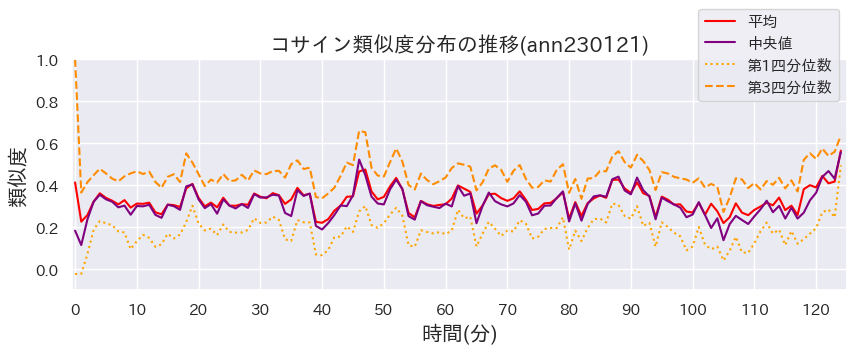

In [17]:
window_sizes = [1]
for window in window_sizes:
    df_vectors['q1'] = df_vectors['q1'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['q2'] = df_vectors['q2'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['q3'] = df_vectors['q3'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['mean'] = df_vectors['mean'].rolling(
        window=window, min_periods=1).mean()
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.set_title(
        "コサイン類似度分布の推移(ann230121)", fontsize=15)
    indices = range(0, len(df_vectors), 10)
    plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(-0.5, num_rows)
    ax.set_ylim(-0.1, 1)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("類似度", fontsize=15)
    ax.plot(df_vectors["created_at"], df_vectors["mean"], color="red",
            label="平均")
    ax.plot(df_vectors["created_at"], df_vectors["q2"], color="purple",
            label="中央値")
    ax.plot(df_vectors["created_at"], df_vectors["q1"], color="orange", linestyle="dotted",
            label="第1四分位数")
    ax.plot(df_vectors["created_at"], df_vectors["q3"], color="darkorange", linestyle="dashed",
            label="第3四分位数")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1.25))
    plt.savefig('quantile.png')


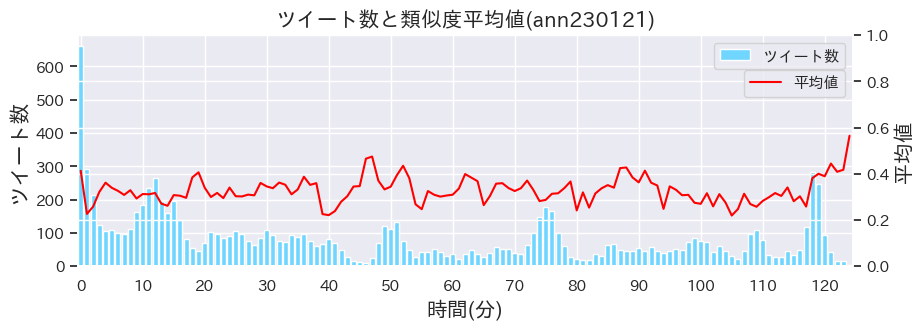

In [18]:
for window in window_sizes:
    df_vectors['tweet'] = df_vectors['tweet'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['mean'] = df_vectors['mean'].rolling(
        window=window, min_periods=1).mean()
    # df_vectors['stdev'] = df_vectors['stdev'].rolling(
    #     window=window, min_periods=1).mean()
    # df_vectors['alpha_m'] = df_vectors['mean'] - df_vectors['stdev']
    # df_vectors['alpha_p'] = df_vectors['mean'] + df_vectors['stdev']

    fig, ax = plt.subplots(figsize=(10, 3))
    ax.set_title(
        "ツイート数と類似度平均値(ann230121)", fontsize=15)
    indices = range(0, len(df_vectors), 10)
    plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(-0.5, num_rows - 0.5)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("ツイート数", fontsize=15)
    ax.bar(df_vectors["created_at"], df_vectors["tweet"],
           color="#70d6ff", label="ツイート数")
    ax2 = ax.twinx()
    ax2.set_ylim(0, 1)
    ax2.set_ylabel("平均値", fontsize=15)
    ax2.plot(df_vectors["created_at"], df_vectors["mean"], color="red", label="平均値")
    # ax2.plot(df_vectors["created_at"], df_vectors["alpha_m"], color="orange", linestyle="dashed")
    # ax2.plot(df_vectors["created_at"], df_vectors["alpha_p"], color="orange", linestyle="dashed",label="68%信頼区間")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
    ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.88))
    plt.savefig('mean.png')


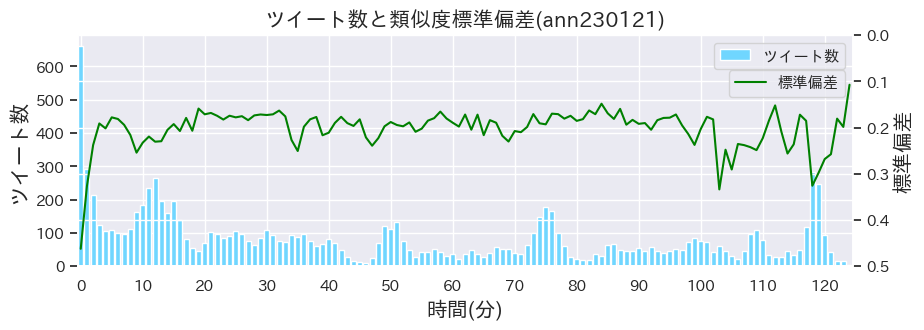

In [20]:
for window in window_sizes:
    df_vectors['tweet'] = df_vectors['tweet'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['stdev'] = df_vectors['stdev'].rolling(
        window=window, min_periods=1).mean()
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.set_title(
        "ツイート数と類似度標準偏差(ann230121)", fontsize=15)
    indices = range(0, len(df_vectors), 10)
    plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(-0.5, num_rows - 0.5)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("ツイート数", fontsize=15)
    ax.bar(df_vectors["created_at"], df_vectors["tweet"],
           color="#70d6ff", label="ツイート数")
    ax2 = ax.twinx()
    ax2.set_ylim(0.5, 0)
    ax2.set_ylabel("標準偏差", fontsize=15)
    ax2.plot(df_vectors["created_at"], df_vectors["stdev"], color="green",
             label="標準偏差")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
    ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.88))
    plt.savefig('stdev.png')
